In this Project, I will focus on the technical side of Finding & Testing which tools help to speed up your research progess & accuracy most.

### cuML: CUDA for Machine Learning Model Example

In [ ]:
%load_ext cuml.accel

cuML: Accelerator installed.


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [ ]:
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)

#? Filter anoying warning when evaluate model
import warnings
warnings.filterwarnings("ignore", message="Unused keyword parameter")

## 1. Data Preration

In [ ]:
if not os.path.exists('cleveland.csv'):
    !gdown 16HPyuXWXPptt5g3xvS_kR_wXAfjpR1Ju

Downloading...
From: https://drive.google.com/uc?id=16HPyuXWXPptt5g3xvS_kR_wXAfjpR1Ju
To: /content/cleveland.csv
100% 10.9k/10.9k [00:00<00:00, 45.1MB/s]


## A. Model Preparation

### B. Đọc và cấu trúc hóa tập dữ liệu

In [ ]:
DATA_PATH = 'cleveland.csv'
COLUMNS = ['age','sex','cp','trestbps','chol','fbs','restecg',
           'thalach','exang','oldpeak','slope','ca','thal','target']

numeric_cols = ['age','trestbps','chol','thalach','oldpeak']
categorical_cols = ['sex','cp','fbs','restecg','exang','slope','ca','thal']

K_features = 10
raw = pd.read_csv(DATA_PATH, header=None)
raw.columns = COLUMNS

for c in ['age','trestbps','chol','thalach','oldpeak','ca','thal']:
    raw[c] = pd.to_numeric(raw[c], errors='coerce')

raw['target'] = (raw['target'] > 0).astype(int)
print('Shape:', raw.shape)
display(raw.head())
display(raw.isna().sum())

Shape: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


### C. Chia tập dữ liệu

In [ ]:
TARGET = 'target'
raw_feature_cols = [c for c in raw.columns if c != TARGET]
X_all = raw[raw_feature_cols]
y_all = raw[TARGET]

X_train, X_temp, y_train, y_temp = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

### D. Xây dựng bộ dữ liệu gốc (đã được xử lý)

In [ ]:
cat_proc = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', MinMaxScaler())
])
num_proc = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocess = ColumnTransformer([
    ('num', num_proc, numeric_cols),
    ('cat', cat_proc, categorical_cols),
])
raw_pipeline = Pipeline([
    ('preprocess', preprocess),
])

X_raw_train = raw_pipeline.fit_transform(X_train, y_train)
X_raw_val = raw_pipeline.transform(X_val)
X_raw_test = raw_pipeline.transform(X_test)

preprocessed_feature_names = []
for name, transformer, columns in preprocess.transformers_:
    if hasattr(transformer, 'get_feature_names_out'):
        preprocessed_feature_names.extend(transformer.get_feature_names_out(columns))
    else:
        preprocessed_feature_names.extend(columns)

X_raw_train_df = pd.DataFrame(X_raw_train, columns=preprocessed_feature_names, index=X_train.index)
X_raw_val_df = pd.DataFrame(X_raw_val, columns=preprocessed_feature_names, index=X_val.index)
X_raw_test_df = pd.DataFrame(X_raw_test, columns=preprocessed_feature_names, index=X_test.index)

out_dir = Path('splits'); out_dir.mkdir(parents=True, exist_ok=True)
pd.concat([X_raw_train_df, y_train.rename(TARGET)], axis=1).to_csv(out_dir / 'raw_train.csv', index=False)
pd.concat([X_raw_val_df, y_val.rename(TARGET)], axis=1).to_csv(out_dir / 'raw_val.csv', index=False)
pd.concat([X_raw_test_df, y_test.rename(TARGET)], axis=1).to_csv(out_dir / 'raw_test.csv', index=False)

display(X_raw_train_df)

,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal
180,-0.729485,-0.395692,0.458139,0.708371,-0.445445,1.0,1.000000,0.0,1.0,0.0,0.5,0.000000,1.0
208,0.050166,-0.054513,0.230598,0.222495,-0.891627,1.0,0.333333,0.0,0.0,0.0,0.0,0.000000,0.0
167,-0.061212,0.059213,0.723605,0.399178,-0.891627,0.0,0.333333,1.0,1.0,1.0,0.0,0.333333,0.0
105,-0.061212,-1.305501,1.121803,0.266666,-0.891627,1.0,0.333333,0.0,0.0,0.0,0.0,0.000000,1.0
297,0.272924,0.514117,-0.167601,-1.190962,-0.713154,0.0,1.000000,0.0,0.0,1.0,0.5,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,0.829818,0.514117,2.733557,0.310836,0.179210,0.0,1.000000,0.0,1.0,0.0,0.5,0.000000,0.0
136,1.720848,0.798433,-1.438042,-1.102621,1.428521,1.0,1.000000,0.0,0.0,1.0,1.0,0.000000,1.0
2,1.386712,-0.623144,-0.395142,-0.925938,1.428521,1.0,1.000000,0.0,1.0,1.0,0.5,0.666667,1.0
189,1.609469,0.514117,0.078903,-0.175039,0.893102,1.0,0.666667,0.0,1.0,0.0,0.5,1.000000,1.0


### E. Tạo bộ dữ liệu mới với Decision Tree

In [ ]:
dt_feature_selection_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('decision_tree', DecisionTreeClassifier(random_state=42))
])

dt_feature_selection_pipeline.fit(X_train, y_train)
feature_importance_series = pd.Series(
    dt_feature_selection_pipeline.named_steps['decision_tree'].feature_importances_,
    index=preprocessed_feature_names
)
sorted_feature_importances = feature_importance_series.sort_values(ascending=False)
display(sorted_feature_importances)

selected_features = sorted_feature_importances.head(K_features).index.tolist()
print(f'Top {K_features} selected features: {selected_features}')

X_dt_train = X_raw_train_df[selected_features]
X_dt_val = X_raw_val_df[selected_features]
X_dt_test = X_raw_test_df[selected_features]
display(X_dt_train.head())

pd.concat([X_dt_train, y_train.rename(TARGET)], axis=1).to_csv(out_dir / 'dt_train.csv', index=False)
pd.concat([X_dt_val, y_val.rename(TARGET)], axis=1).to_csv(out_dir / 'dt_val.csv', index=False)
pd.concat([X_dt_test, y_test.rename(TARGET)], axis=1).to_csv(out_dir / 'dt_test.csv', index=False)

,0
thal,0.292921
cp,0.126362
ca,0.118425
oldpeak,0.109681
chol,0.097347
age,0.074188
thalach,0.073157
sex,0.033909
slope,0.025014
exang,0.015216


Top 10 selected features: ['thal', 'cp', 'ca', 'oldpeak', 'chol', 'age', 'thalach', 'sex', 'slope', 'exang']


,thal,cp,ca,oldpeak,chol,age,thalach,sex,slope,exang
180,1.0,1.000000,0.000000,-0.445445,0.458139,-0.729485,0.708371,1.0,0.5,0.0
208,0.0,0.333333,0.000000,-0.891627,0.230598,0.050166,0.222495,1.0,0.0,0.0
167,0.0,0.333333,0.333333,-0.891627,0.723605,-0.061212,0.399178,0.0,0.0,1.0
105,1.0,0.333333,0.000000,-0.891627,1.121803,-0.061212,0.266666,1.0,0.0,0.0
297,1.0,1.000000,0.000000,-0.713154,-0.167601,0.272924,-1.190962,0.0,0.5,1.0


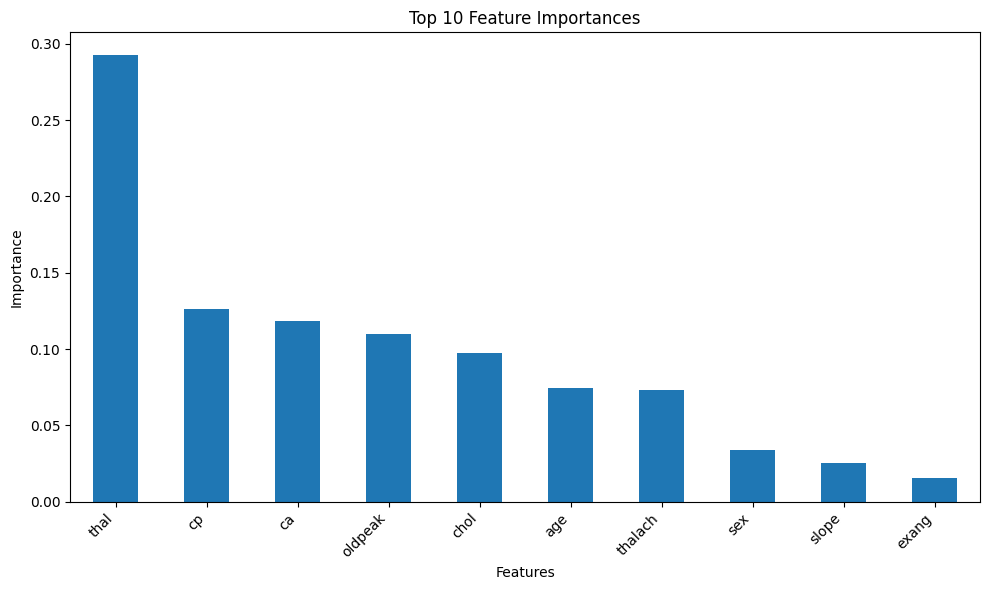

In [ ]:
plt.figure(figsize=(10, 6))
sorted_feature_importances.head(K_features).plot(kind='bar')
plt.title(f'Top {K_features} Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 2. Feature Engineering Transformer

### H. Add new features (chol/age, etc.)

In [ ]:
def add_new_features_func(df):
    df = df.copy()
    if {'chol','age'} <= set(df.columns):
        df['chol_per_age'] = df['chol']/df['age']
    if {'trestbps','age'} <= set(df.columns):
        df['bps_per_age'] = df['trestbps']/df['age']
    if {'thalach','age'} <= set(df.columns):
        df['hr_ratio'] = df['thalach']/df['age']
    if 'age' in df.columns:
        df['age_bin'] = pd.cut(df['age'], bins=5, labels=False).astype('category')
    return df

In [ ]:
class AddNewFeaturesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.columns_ = X.columns
        self.new_features_ = []
        if {'chol','age'} <= set(X.columns):
            self.new_features_.append('chol_per_age')
        if {'trestbps','age'} <= set(X.columns):
            self.new_features_.append('bps_per_age')
        if {'thalach','age'} <= set(X.columns):
            self.new_features_.append('hr_ratio')
        if 'age' in X.columns:
            self.new_features_.append('age_bin')
        return self

    def transform(self, X):
        return add_new_features_func(X)

    def get_feature_names_out(self, input_features=None):
        return list(self.columns_) + self.new_features_


### G. Build Feature Engineering pipeline

In [ ]:
gen_num = ['chol_per_age','bps_per_age','hr_ratio']
gen_cat = ['age_bin']
all_nums = [c for c in numeric_cols] + gen_num
all_cats = [c for c in categorical_cols] + gen_cat

num_proc = Pipeline([('imp', SimpleImputer(strategy='median')),
                     ('sc', StandardScaler())])
cat_proc = Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                     ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

pre = ColumnTransformer([
    ('num', num_proc, all_nums),
    ('cat', cat_proc, all_cats),
], verbose_feature_names_out=False).set_output(transform='pandas')

fe_pre = Pipeline([
    ('add', AddNewFeaturesTransformer()),
    ('pre', pre),
]).set_output(transform='pandas')

Xt_tr = fe_pre.fit_transform(X_train, y_train)
Xt_va = fe_pre.transform(X_val)
Xt_te = fe_pre.transform(X_test)

nz_cols = Xt_tr.columns[Xt_tr.nunique(dropna=False) > 1]
Xt_tr = Xt_tr[nz_cols]
Xt_va = Xt_va[nz_cols]
Xt_te = Xt_te[nz_cols]

### J. Feature selection with Mutual Information

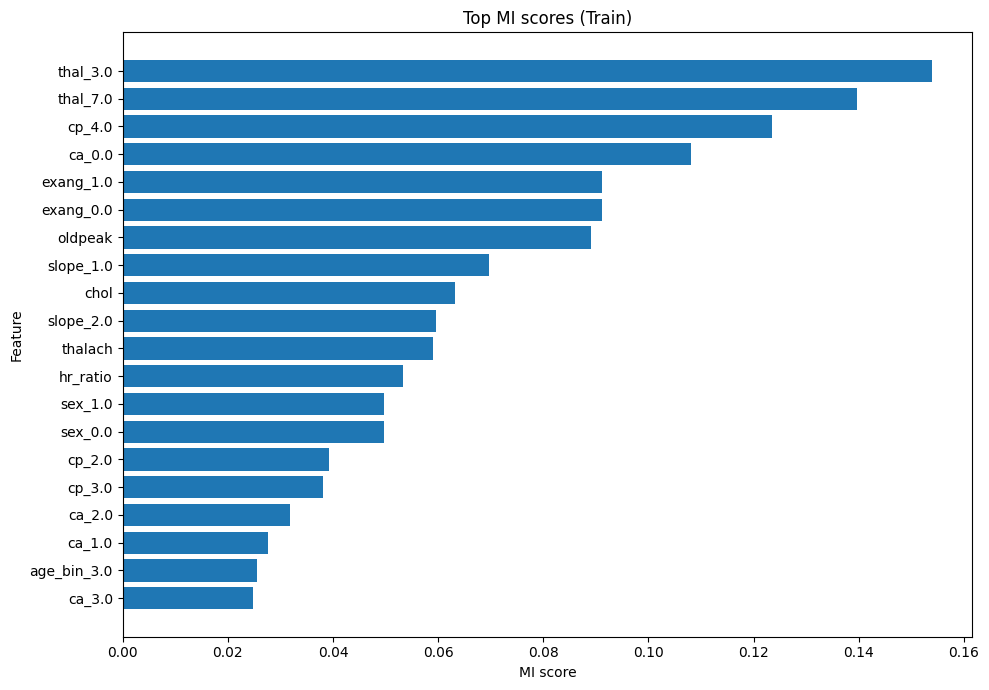

,fe_topk_features
0,thal_3.0
1,thal_7.0
2,cp_4.0
3,ca_0.0
4,exang_1.0
5,exang_0.0
6,oldpeak
7,slope_1.0
8,chol
9,slope_2.0


In [ ]:
ohe = fe_pre.named_steps['pre'].named_transformers_['cat'].named_steps['ohe']
cat_names = list(ohe.get_feature_names_out(all_cats))
is_discrete = np.array([c in cat_names for c in Xt_tr.columns], dtype=bool)

mi = mutual_info_classif(Xt_tr.values, y_train.values,
                         discrete_features=is_discrete,
                         random_state=42)

mi_series = pd.Series(mi, index=Xt_tr.columns).sort_values(ascending=False)

N = min(20, len(mi_series))
topN = mi_series.head(N).iloc[::-1]
plt.figure(figsize=(10, max(6, 0.35*N)))
plt.barh(topN.index, topN.values)
plt.title('Top MI scores (Train)')
plt.xlabel('MI score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('top_mi_scores.pdf', bbox_inches='tight')
plt.show()

K = raw.columns.drop('target').shape[0]
topk_cols = list(mi_series.head(K).index)
fe_tr = Xt_tr[topk_cols].assign(target=y_train.values)
fe_va = Xt_va[topk_cols].assign(target=y_val.values)
fe_te = Xt_te[topk_cols].assign(target=y_test.values)

out = Path('splits'); out.mkdir(parents=True, exist_ok=True)
fe_tr.to_csv(out/'fe_train.csv', index=False)
fe_va.to_csv(out/'fe_val.csv', index=False)
fe_te.to_csv(out/'fe_test.csv', index=False)

display(pd.Series(topk_cols, name='fe_topk_features').reset_index(drop=True))

### K. Feature selection on FE dataset with Decision Tree

In [ ]:
dt_fe_feature_selection_pipeline = Pipeline([
    ('preprocess', fe_pre),
    ('decision_tree', DecisionTreeClassifier(random_state=42))
])

dt_fe_feature_selection_pipeline.fit(X_train, y_train)

pipeline_feature_names = dt_fe_feature_selection_pipeline.named_steps['preprocess'].get_feature_names_out()

feature_importance_series = pd.Series(
    dt_fe_feature_selection_pipeline.named_steps['decision_tree'].feature_importances_,
    index=pipeline_feature_names
)
sorted_feature_importances = feature_importance_series.sort_values(ascending=False)

selected_features = sorted_feature_importances.head(K_features).index.tolist()
print(f'Top {K_features} selected features: {selected_features}')

X_fe_dt_train = Xt_tr[selected_features]
X_fe_dt_val = Xt_va[selected_features]
X_fe_dt_test = Xt_te[selected_features]
display(X_fe_dt_train.head())

pd.concat([X_fe_dt_train, y_train.rename(TARGET)], axis=1).to_csv(out_dir / 'fe_dt_train.csv', index=False)
pd.concat([X_fe_dt_val, y_val.rename(TARGET)], axis=1).to_csv(out_dir / 'fe_dt_val.csv', index=False)
pd.concat([X_fe_dt_test, y_test.rename(TARGET)], axis=1).to_csv(out_dir / 'fe_dt_test.csv', index=False)


Top 10 selected features: ['thal_3.0', 'cp_4.0', 'ca_0.0', 'chol_per_age', 'hr_ratio', 'oldpeak', 'chol', 'age', 'exang_0.0', 'cp_3.0']


,thal_3.0,cp_4.0,ca_0.0,chol_per_age,hr_ratio,oldpeak,chol,age,exang_0.0,cp_3.0
180,0.0,1.0,1.0,0.952258,0.726265,-0.445445,0.458139,-0.729485,1.0,0.0
208,1.0,0.0,1.0,0.082082,-0.054469,-0.891627,0.230598,0.050166,1.0,0.0
167,1.0,0.0,0.0,0.606839,0.099522,-0.891627,0.723605,-0.061212,0.0,0.0
105,0.0,0.0,1.0,0.965051,0.031766,-0.891627,1.121803,-0.061212,1.0,0.0
297,0.0,1.0,1.0,-0.411237,-0.859761,-0.713154,-0.167601,0.272924,0.0,0.0


### L. Zip datasets for download

In [ ]:
!zip -r dataset.zip splits

  adding: splits/ (stored 0%)
  adding: splits/raw_val.csv (deflated 67%)
  adding: splits/fe_train.csv (deflated 74%)
  adding: splits/fe_dt_train.csv (deflated 69%)
  adding: splits/dt_val.csv (deflated 67%)
  adding: splits/fe_dt_test.csv (deflated 60%)
  adding: splits/dt_test.csv (deflated 66%)
  adding: splits/fe_val.csv (deflated 64%)
  adding: splits/dt_train.csv (deflated 80%)
  adding: splits/fe_test.csv (deflated 64%)
  adding: splits/raw_test.csv (deflated 67%)
  adding: splits/raw_train.csv (deflated 81%)
  adding: splits/fe_dt_val.csv (deflated 61%)


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Copy the zip file to your Google Drive
# !cp dataset.zip /content/drive/MyDrive/datas

Mounted at /content/drive


In [ ]:
# !cp /content/drive/MyDrive/datas/dataset.zip .
# !unzip -o dataset.zip

# Random Forest

In [ ]:
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [ ]:
# https://drive.google.com/drive/folders/1cMoqIDEgGYDVzv8B7cKp3csxujQ4OFp7?usp=drive_link
if not os.path.exists('dataset_v3'):
    !gdown --folder 1cMoqIDEgGYDVzv8B7cKp3csxujQ4OFp7

## 3. Dataset Reader Utility

In [ ]:
def read_csv(file_path):
    df = pd.read_csv(file_path)
    display(df.head())

    X = df.drop('target', axis=1)
    y = df['target']
    display(y.value_counts())

    print('Shape df: ', df.shape)
    print('Shape X: ', X.shape)
    print('Shape y: ', y.shape)

    return X, y


### Load all datasets (Original, FE, DT, FE+DT)

In [ ]:
# Original Dataset
X_train, y_train = read_csv('dataset_v3/raw_train.csv')
X_val, y_val = read_csv('dataset_v3/raw_val.csv')
X_test, y_test = read_csv('dataset_v3/raw_test.csv')

# FE Dataset
X_fe_train, y_fe_train = read_csv('dataset_v3/fe_train.csv')
X_fe_val, y_fe_val = read_csv('dataset_v3/fe_val.csv')
X_fe_test, y_fe_test = read_csv('dataset_v3/fe_test.csv')

# Original + DT Dataset
X_dt_train, y_dt_train = read_csv('dataset_v3/dt_train.csv')
X_dt_val, y_dt_val = read_csv('dataset_v3/dt_val.csv')
X_dt_test, y_dt_test = read_csv('dataset_v3/dt_test.csv')

# FE + DT Dataset
X_fe_dt_train, y_fe_dt_train = read_csv('dataset_v3/fe_dt_train.csv')
X_fe_dt_val, y_fe_dt_val = read_csv('dataset_v3/fe_dt_val.csv')
X_fe_dt_test, y_fe_dt_test = read_csv('dataset_v3/fe_dt_test.csv')

,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal,target
0,-0.729485,-0.395692,0.458139,0.708371,-0.445445,1.0,1.000000,0.0,1.0,0.0,0.5,0.000000,1.0,1
1,0.050166,-0.054513,0.230598,0.222495,-0.891627,1.0,0.333333,0.0,0.0,0.0,0.0,0.000000,0.0,0
2,-0.061212,0.059213,0.723605,0.399178,-0.891627,0.0,0.333333,1.0,1.0,1.0,0.0,0.333333,0.0,0
3,-0.061212,-1.305501,1.121803,0.266666,-0.891627,1.0,0.333333,0.0,0.0,0.0,0.0,0.000000,1.0,0
4,0.272924,0.514117,-0.167601,-1.190962,-0.713154,0.0,1.000000,0.0,0.0,1.0,0.5,0.000000,1.0,1


,count
target,
0,131
1,111


Shape df:  (242, 14)
Shape X:  (242, 13)
Shape y:  (242,)


,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal,target
0,-1.063621,0.400391,-0.262410,0.089984,-0.713154,0.0,1.000000,0.0,1.0,1.0,0.5,0.0,0.0,0
1,1.720848,-0.054513,1.368307,-1.809349,1.250048,1.0,1.000000,0.0,1.0,0.0,0.5,1.0,0.0,1
2,-0.061212,1.082748,-0.338257,0.664201,0.536156,1.0,0.666667,0.0,1.0,0.0,0.0,0.0,1.0,0
3,0.941197,0.229802,0.040979,0.973394,-0.891627,0.0,0.666667,0.0,1.0,0.0,0.0,0.0,0.0,0
4,0.495681,0.229802,-0.300333,0.487519,-0.445445,1.0,1.000000,0.0,0.0,0.0,0.5,0.0,1.0,0


,count
target,
0,16
1,14


Shape df:  (30, 14)
Shape X:  (30, 13)
Shape y:  (30,)


,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal,target
0,0.384303,-0.168240,-0.641646,-0.837597,1.071575,1.0,1.000000,0.0,1.0,1.0,0.5,1.0,1.0,1
1,-2.288787,-0.736870,-1.286348,1.061736,-0.891627,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0
2,0.829818,-0.054513,-0.357219,-0.175039,0.714629,1.0,0.666667,0.0,0.0,0.0,0.5,1.0,1.0,0
3,-0.395349,-0.054513,0.116827,-0.042528,-0.445445,0.0,0.666667,0.0,1.0,0.0,0.0,0.0,0.0,0
4,-1.397757,-0.623144,-0.186562,1.945146,-0.177735,1.0,0.666667,1.0,0.0,0.0,1.0,0.0,1.0,0


,count
target,
0,17
1,14


Shape df:  (31, 14)
Shape X:  (31, 13)
Shape y:  (31,)


,thal_3.0,thal_7.0,cp_4.0,ca_0.0,exang_1.0,exang_0.0,oldpeak,slope_1.0,chol,slope_2.0,thalach,hr_ratio,sex_1.0,target
0,0.0,1.0,1.0,1.0,0.0,1.0,-0.445445,0.0,0.458139,1.0,0.708371,0.726265,1.0,1
1,1.0,0.0,0.0,1.0,0.0,1.0,-0.891627,1.0,0.230598,0.0,0.222495,-0.054469,1.0,0
2,1.0,0.0,0.0,0.0,1.0,0.0,-0.891627,1.0,0.723605,0.0,0.399178,0.099522,0.0,0
3,0.0,1.0,0.0,1.0,0.0,1.0,-0.891627,1.0,1.121803,0.0,0.266666,0.031766,1.0,0
4,0.0,1.0,1.0,1.0,1.0,0.0,-0.713154,0.0,-0.167601,1.0,-1.190962,-0.859761,0.0,1


,count
target,
0,131
1,111


Shape df:  (242, 14)
Shape X:  (242, 13)
Shape y:  (242,)


,thal_3.0,thal_7.0,cp_4.0,ca_0.0,exang_1.0,exang_0.0,oldpeak,slope_1.0,chol,slope_2.0,thalach,hr_ratio,sex_1.0,target
0,1.0,0.0,1.0,1.0,1.0,0.0,-0.713154,0.0,-0.262410,1.0,0.089984,0.628019,0.0,0
1,1.0,0.0,1.0,0.0,0.0,1.0,1.250048,0.0,1.368307,1.0,-1.809349,-1.592443,1.0,1
2,0.0,1.0,0.0,1.0,0.0,1.0,0.536156,1.0,-0.338257,0.0,0.664201,0.235034,1.0,0
3,1.0,0.0,0.0,1.0,0.0,1.0,-0.891627,1.0,0.040979,0.0,0.973394,-0.161823,0.0,0
4,0.0,1.0,1.0,1.0,0.0,1.0,-0.445445,0.0,-0.300333,1.0,0.487519,-0.163464,1.0,0


,count
target,
0,16
1,14


Shape df:  (30, 14)
Shape X:  (30, 13)
Shape y:  (30,)


,thal_3.0,thal_7.0,cp_4.0,ca_0.0,exang_1.0,exang_0.0,oldpeak,slope_1.0,chol,slope_2.0,thalach,hr_ratio,sex_1.0,target
0,0.0,1.0,1.0,0.0,1.0,0.0,1.071575,0.0,-0.641646,1.0,-0.837597,-0.736915,1.0,1
1,1.0,0.0,0.0,1.0,0.0,1.0,-0.891627,1.0,-1.286348,0.0,1.061736,2.749978,1.0,0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.714629,0.0,-0.357219,1.0,-0.175039,-0.619566,1.0,0
3,1.0,0.0,0.0,1.0,0.0,1.0,-0.445445,1.0,0.116827,0.0,-0.042528,0.071622,0.0,0
4,0.0,1.0,0.0,1.0,0.0,1.0,-0.177735,0.0,-0.186562,0.0,1.945146,2.141882,1.0,0


,count
target,
0,17
1,14


Shape df:  (31, 14)
Shape X:  (31, 13)
Shape y:  (31,)


,thal,cp,ca,oldpeak,chol,age,thalach,sex,slope,exang,target
0,1.0,1.000000,0.000000,-0.445445,0.458139,-0.729485,0.708371,1.0,0.5,0.0,1
1,0.0,0.333333,0.000000,-0.891627,0.230598,0.050166,0.222495,1.0,0.0,0.0,0
2,0.0,0.333333,0.333333,-0.891627,0.723605,-0.061212,0.399178,0.0,0.0,1.0,0
3,1.0,0.333333,0.000000,-0.891627,1.121803,-0.061212,0.266666,1.0,0.0,0.0,0
4,1.0,1.000000,0.000000,-0.713154,-0.167601,0.272924,-1.190962,0.0,0.5,1.0,1


,count
target,
0,131
1,111


Shape df:  (242, 11)
Shape X:  (242, 10)
Shape y:  (242,)


,thal,cp,ca,oldpeak,chol,age,thalach,sex,slope,exang,target
0,0.0,1.000000,0.0,-0.713154,-0.262410,-1.063621,0.089984,0.0,0.5,1.0,0
1,0.0,1.000000,1.0,1.250048,1.368307,1.720848,-1.809349,1.0,0.5,0.0,1
2,1.0,0.666667,0.0,0.536156,-0.338257,-0.061212,0.664201,1.0,0.0,0.0,0
3,0.0,0.666667,0.0,-0.891627,0.040979,0.941197,0.973394,0.0,0.0,0.0,0
4,1.0,1.000000,0.0,-0.445445,-0.300333,0.495681,0.487519,1.0,0.5,0.0,0


,count
target,
0,16
1,14


Shape df:  (30, 11)
Shape X:  (30, 10)
Shape y:  (30,)


,thal,cp,ca,oldpeak,chol,age,thalach,sex,slope,exang,target
0,1.0,1.000000,1.0,1.071575,-0.641646,0.384303,-0.837597,1.0,0.5,1.0,1
1,0.0,0.000000,0.0,-0.891627,-1.286348,-2.288787,1.061736,1.0,0.0,0.0,0
2,1.0,0.666667,1.0,0.714629,-0.357219,0.829818,-0.175039,1.0,0.5,0.0,0
3,0.0,0.666667,0.0,-0.445445,0.116827,-0.395349,-0.042528,0.0,0.0,0.0,0
4,1.0,0.666667,0.0,-0.177735,-0.186562,-1.397757,1.945146,1.0,1.0,0.0,0


,count
target,
0,17
1,14


Shape df:  (31, 11)
Shape X:  (31, 10)
Shape y:  (31,)


,thal_3.0,cp_4.0,ca_0.0,chol_per_age,hr_ratio,oldpeak,chol,age,exang_0.0,cp_3.0,target
0,0.0,1.0,1.0,0.952258,0.726265,-0.445445,0.458139,-0.729485,1.0,0.0,1
1,1.0,0.0,1.0,0.082082,-0.054469,-0.891627,0.230598,0.050166,1.0,0.0,0
2,1.0,0.0,0.0,0.606839,0.099522,-0.891627,0.723605,-0.061212,0.0,0.0,0
3,0.0,0.0,1.0,0.965051,0.031766,-0.891627,1.121803,-0.061212,1.0,0.0,0
4,0.0,1.0,1.0,-0.411237,-0.859761,-0.713154,-0.167601,0.272924,0.0,0.0,1


,count
target,
0,131
1,111


Shape df:  (242, 11)
Shape X:  (242, 10)
Shape y:  (242,)


,thal_3.0,cp_4.0,ca_0.0,chol_per_age,hr_ratio,oldpeak,chol,age,exang_0.0,cp_3.0,target
0,1.0,1.0,1.0,0.524962,0.628019,-0.713154,-0.262410,-1.063621,0.0,0.0,0
1,1.0,1.0,0.0,-0.068646,-1.592443,1.250048,1.368307,1.720848,1.0,0.0,1
2,0.0,0.0,1.0,-0.348393,0.235034,0.536156,-0.338257,-0.061212,1.0,1.0,0
3,1.0,0.0,1.0,-0.621316,-0.161823,-0.891627,0.040979,0.941197,1.0,1.0,0
4,0.0,1.0,1.0,-0.652540,-0.163464,-0.445445,-0.300333,0.495681,1.0,0.0,0


,count
target,
0,16
1,14


Shape df:  (30, 11)
Shape X:  (30, 10)
Shape y:  (30,)


,thal_3.0,cp_4.0,ca_0.0,chol_per_age,hr_ratio,oldpeak,chol,age,exang_0.0,cp_3.0,target
0,0.0,1.0,0.0,-0.875417,-0.736915,1.071575,-0.641646,0.384303,0.0,0.0,1
1,1.0,0.0,1.0,0.624900,2.749978,-0.891627,-1.286348,-2.288787,1.0,0.0,0
2,0.0,0.0,0.0,-0.873880,-0.619566,0.714629,-0.357219,0.829818,1.0,1.0,0
3,1.0,0.0,1.0,0.317862,0.071622,-0.445445,0.116827,-0.395349,1.0,1.0,0
4,0.0,0.0,1.0,0.957741,2.141882,-0.177735,-0.186562,-1.397757,1.0,1.0,0


,count
target,
0,17
1,14


Shape df:  (31, 11)
Shape X:  (31, 10)
Shape y:  (31,)


## 4. Random Forest Optimization & Evaluation

### Find optimal n_estimators for Random Forest

In [ ]:
# !pip install -q cuml-cu11 --extra-index-url=https://pypi.nvidia.com
# !pip install -q optuna hummingbird-ml

In [ ]:
# from hummingbird.ml import convert

# def to_hb(model):
#     hb_model = convert(model, 'pytorch')
#     hb_model.to('cuda')
#     print(f'apply hummingbird-ml to {model}')
#     return hb_model

### Testing hummingbird-ml & cuML to speed up inference

Paste on top: %load_ext cuml.accel  

In [ ]:
from cuml.ensemble import RandomForestClassifier  # if you want GPU only

In [ ]:
%reload_ext cuml.accel

def original_find_optimal_rf(
    X_train, y_train,
    n_estimators_range=range(50, 501, 50), cv_splits=3,
    max_depth=5, min_samples_split=2, min_samples_leaf=1,
    max_features='sqrt', bootstrap=True, class_weight=None
):

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=SEED)
    scores = []
    for n in n_estimators_range:
        rf = RandomForestClassifier(
            n_estimators=n, max_depth=max_depth,
            min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
            max_features=max_features, bootstrap=bootstrap,
            class_weight=class_weight, random_state=SEED
        )
        cv_score = cross_val_score(rf, X_train, y_train,
                                   cv=cv, scoring='accuracy')
        scores.append(cv_score.mean())

    plt.figure(figsize=(10, 6))
    plt.plot(list(n_estimators_range), scores, 'bo-')
    plt.title(f'Chọn n_estimators tối ưu cho Random Forest (CV={cv_splits}-fold)')
    plt.xlabel('n_estimators')
    plt.ylabel('Cross-Validation Accuracy')
    plt.grid(True)
    plt.show()

    best_n = list(n_estimators_range)[int(np.argmax(scores))]
    print(f'n_estimators tối ưu (CV): {best_n}')

    best_model = RandomForestClassifier(
        n_estimators=best_n, max_depth=max_depth,
        min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
        max_features=max_features, bootstrap=bootstrap,
        class_weight=class_weight, n_jobs=-1, random_state=SEED
    )
    best_model.fit(X_train, y_train)
    return best_model, best_n, max(scores)


cuML: Accelerator installed.


### Train/Validate & Test functions

In [ ]:
def evaluate_val_rf(
    X_train, y_train, X_val, y_val,
    n_estimators_range=range(50, 501, 50), cv_splits=5,
    max_depth=5, min_samples_split=2, min_samples_leaf=1,
    max_features='sqrt', bootstrap=True, class_weight=None
):
    print('Tìm n_estimators tối ưu cho Random Forest...')
    rf_model, best_n, cv_acc = original_find_optimal_rf(
        X_train, y_train, n_estimators_range=n_estimators_range, cv_splits=cv_splits,
        max_depth=max_depth, min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf, max_features=max_features,
        bootstrap=bootstrap, class_weight=class_weight
    )

    val_pred = rf_model.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    print(f'\nĐộ chính xác Random Forest trên tập validation: {val_acc:.4f}')
    print('Classification Report:')
    print(classification_report(y_val, val_pred))
    return rf_model, val_acc, {'n_estimators': best_n}


def evaluate_test_rf(rf_model, X_test, y_test):
    test_pred = rf_model.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    print(f'\nĐộ chính xác Random Forest trên tập test: {test_acc:.4f}')
    print('Classification Report:')
    print(classification_report(y_test, test_pred))
    return test_acc

### Run Random Forest on 4 datasets

Attention: Evaluate trên cùng 1 Code Cell/Block sẽ chạy lâu hơn vì 1 lý do gì đó ?

#### Original

In [ ]:
# %%timeit
# #? 1min 56s ± 5.75 s per loop (mean ± std. dev. of 7 runs, 1 loop each) - 16 MINS
# # RF on Original Dataset
# rf_model, val_acc, best_params = evaluate_val_rf(
#     X_train, y_train, X_val, y_val
# )
# test_acc = evaluate_test_rf(rf_model, X_test, y_test)

# # RF on Feature Engineering Dataset
# rf_model, val_fe_acc, best_params = evaluate_val_rf(
#     X_fe_train, y_fe_train, X_fe_val, y_fe_val
# )
# test_fe_acc = evaluate_test_rf(rf_model, X_fe_test, y_fe_test)

# # RF on Original DT Dataset
# rf_model, val_dt_acc, best_params = evaluate_val_rf(
#     X_dt_train, y_dt_train, X_dt_val, y_dt_val
# )
# test_dt_acc = evaluate_test_rf(rf_model, X_dt_test, y_dt_test)

# # RF on Feature Engineering DT Dataset
# rf_model, val_fe_dt_acc, best_params = evaluate_val_rf(
#     X_fe_dt_train, y_fe_dt_train, X_fe_dt_val, y_fe_dt_val
# )
# test_fe_dt_acc = evaluate_test_rf(rf_model, X_fe_dt_test, y_fe_dt_test)

#### cuML

In [ ]:
from cuml.ensemble import RandomForestClassifier  # if you want GPU only

Tìm n_estimators tối ưu cho Random Forest...


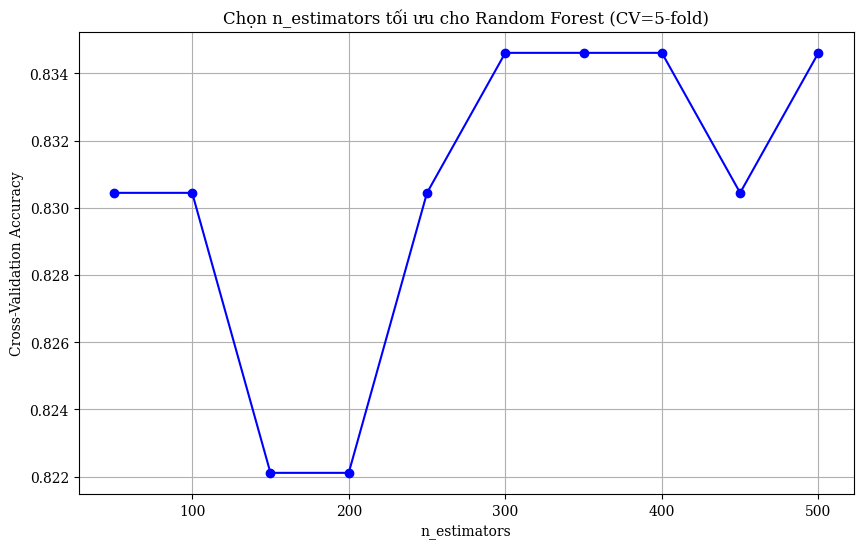

n_estimators tối ưu (CV): 300

Độ chính xác Random Forest trên tập validation: 0.8333
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84        16
           1       0.80      0.86      0.83        14

    accuracy                           0.83        30
   macro avg       0.83      0.83      0.83        30
weighted avg       0.84      0.83      0.83        30


Độ chính xác Random Forest trên tập test: 0.9355
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        17
           1       0.93      0.93      0.93        14

    accuracy                           0.94        31
   macro avg       0.93      0.93      0.93        31
weighted avg       0.94      0.94      0.94        31

0.9354838709677419


In [ ]:
%%timeit
# RF on Feature Engineering Dataset
rf_model, val_fe_acc, best_params = evaluate_val_rf(X_fe_train, y_fe_train, X_fe_val, y_fe_val)
test_fe_acc = evaluate_test_rf(rf_model, X_fe_test, y_fe_test)
print(test_fe_acc)

Tìm n_estimators tối ưu cho Random Forest...


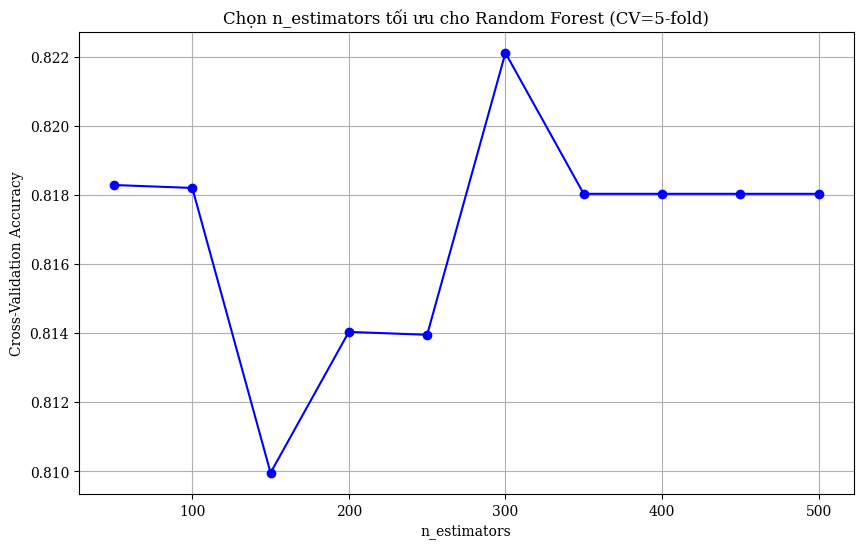

n_estimators tối ưu (CV): 300

Độ chính xác Random Forest trên tập validation: 0.8667
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.81      0.87        16
           1       0.81      0.93      0.87        14

    accuracy                           0.87        30
   macro avg       0.87      0.87      0.87        30
weighted avg       0.87      0.87      0.87        30


Độ chính xác Random Forest trên tập test: 0.8710
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        17
           1       0.86      0.86      0.86        14

    accuracy                           0.87        31
   macro avg       0.87      0.87      0.87        31
weighted avg       0.87      0.87      0.87        31

0.8709677419354839


In [ ]:
%%timeit
# RF on Original Dataset
rf_model, val_acc, best_params = evaluate_val_rf(X_train, y_train, X_val, y_val)
test_acc = evaluate_test_rf(rf_model, X_test, y_test)
print(test_acc)

Tìm n_estimators tối ưu cho Random Forest...


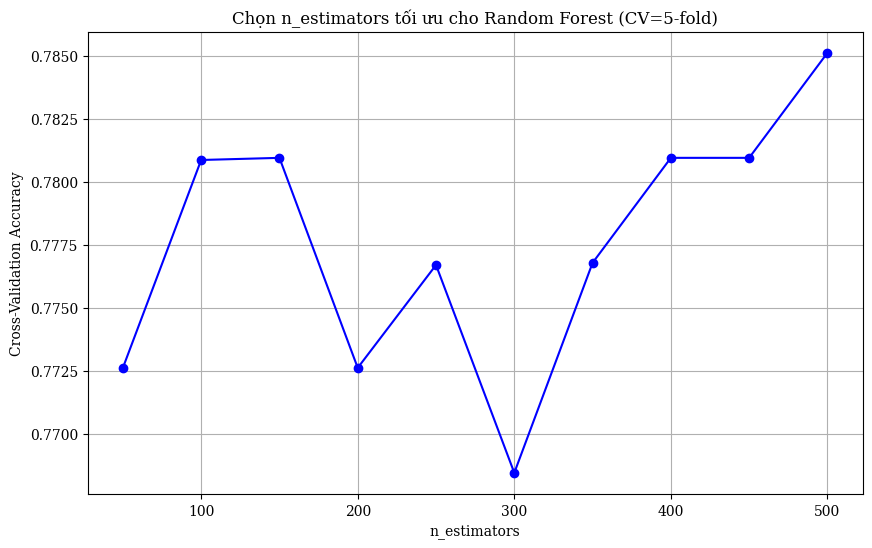

n_estimators tối ưu (CV): 500

Độ chính xác Random Forest trên tập validation: 0.9333
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.93      0.93      0.93        14

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30


Độ chính xác Random Forest trên tập test: 0.9032
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        17
           1       0.87      0.93      0.90        14

    accuracy                           0.90        31
   macro avg       0.90      0.91      0.90        31
weighted avg       0.91      0.90      0.90        31

Tìm n_estimators tối ưu cho Random Forest...


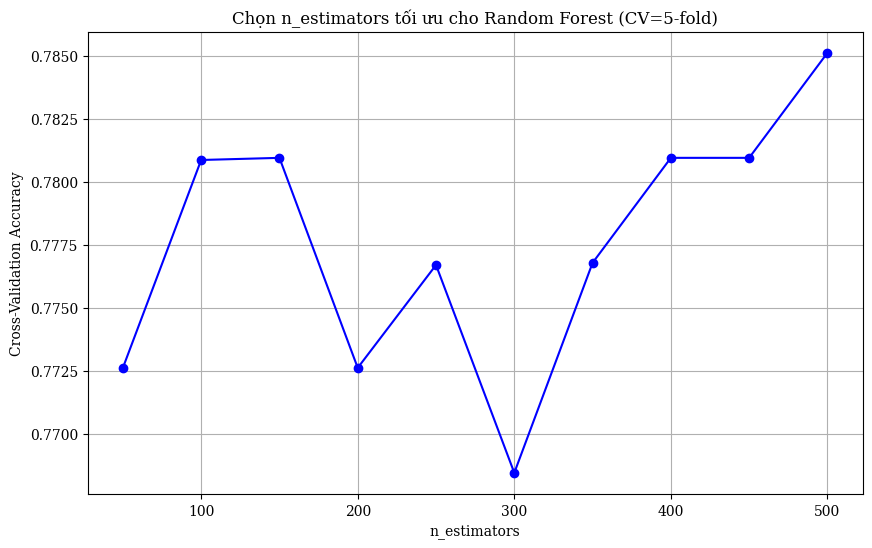

n_estimators tối ưu (CV): 500

Độ chính xác Random Forest trên tập validation: 0.9333
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.93      0.93      0.93        14

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30


Độ chính xác Random Forest trên tập test: 0.9032
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        17
           1       0.87      0.93      0.90        14

    accuracy                           0.90        31
   macro avg       0.90      0.91      0.90        31
weighted avg       0.91      0.90      0.90        31

Tìm n_estimators tối ưu cho Random Forest...


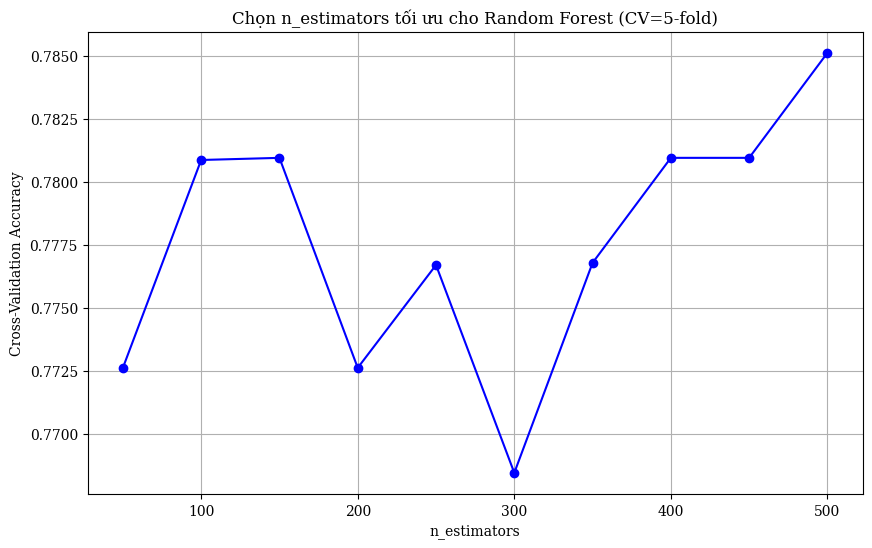

n_estimators tối ưu (CV): 500

Độ chính xác Random Forest trên tập validation: 0.9333
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.93      0.93      0.93        14

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30


Độ chính xác Random Forest trên tập test: 0.9032
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        17
           1       0.87      0.93      0.90        14

    accuracy                           0.90        31
   macro avg       0.90      0.91      0.90        31
weighted avg       0.91      0.90      0.90        31

Tìm n_estimators tối ưu cho Random Forest...


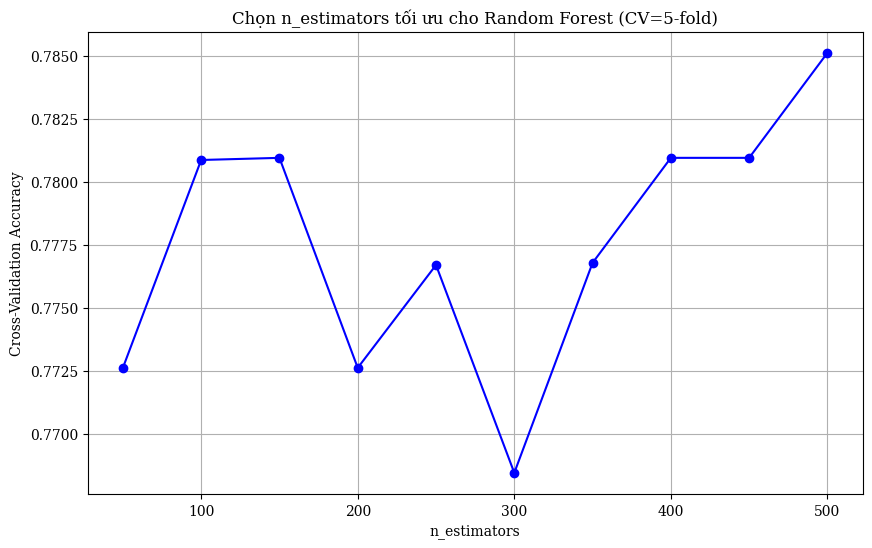

n_estimators tối ưu (CV): 500

Độ chính xác Random Forest trên tập validation: 0.9333
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.93      0.93      0.93        14

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30


Độ chính xác Random Forest trên tập test: 0.9032
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        17
           1       0.87      0.93      0.90        14

    accuracy                           0.90        31
   macro avg       0.90      0.91      0.90        31
weighted avg       0.91      0.90      0.90        31

Tìm n_estimators tối ưu cho Random Forest...


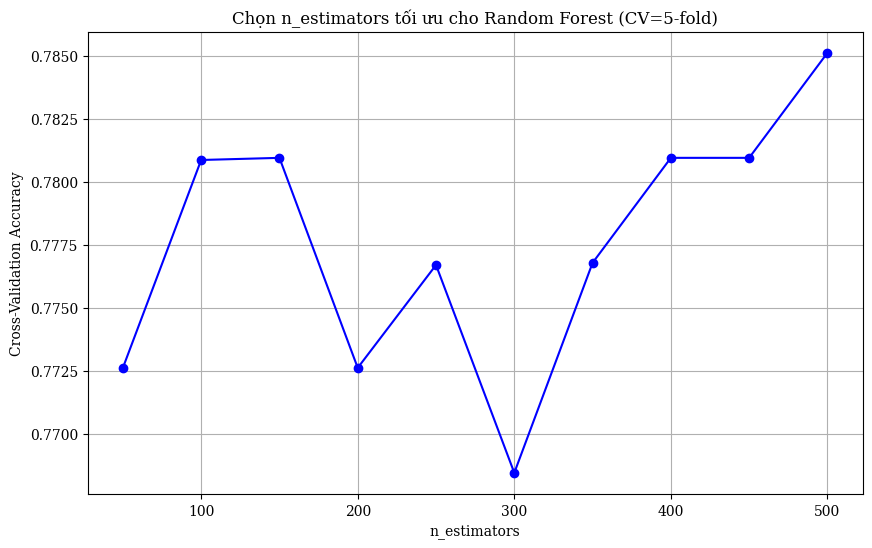

n_estimators tối ưu (CV): 500

Độ chính xác Random Forest trên tập validation: 0.9333
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.93      0.93      0.93        14

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30


Độ chính xác Random Forest trên tập test: 0.9032
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        17
           1       0.87      0.93      0.90        14

    accuracy                           0.90        31
   macro avg       0.90      0.91      0.90        31
weighted avg       0.91      0.90      0.90        31

Tìm n_estimators tối ưu cho Random Forest...


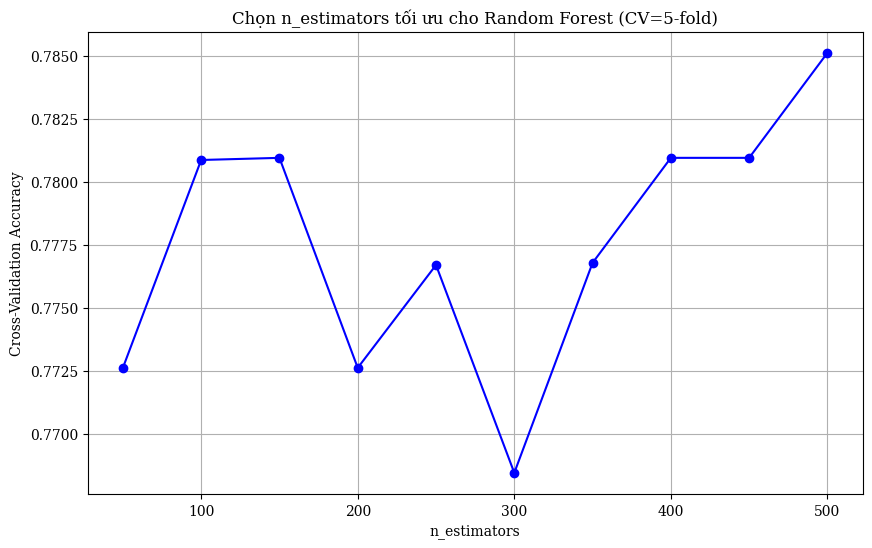

n_estimators tối ưu (CV): 500

Độ chính xác Random Forest trên tập validation: 0.9333
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.93      0.93      0.93        14

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30


Độ chính xác Random Forest trên tập test: 0.9032
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        17
           1       0.87      0.93      0.90        14

    accuracy                           0.90        31
   macro avg       0.90      0.91      0.90        31
weighted avg       0.91      0.90      0.90        31

Tìm n_estimators tối ưu cho Random Forest...


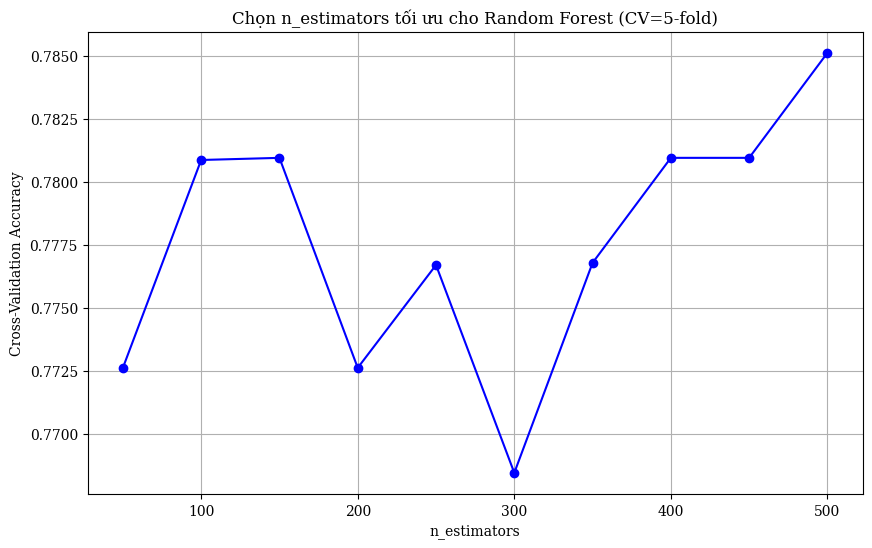

n_estimators tối ưu (CV): 500

Độ chính xác Random Forest trên tập validation: 0.9333
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.93      0.93      0.93        14

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30


Độ chính xác Random Forest trên tập test: 0.9032
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        17
           1       0.87      0.93      0.90        14

    accuracy                           0.90        31
   macro avg       0.90      0.91      0.90        31
weighted avg       0.91      0.90      0.90        31

Tìm n_estimators tối ưu cho Random Forest...


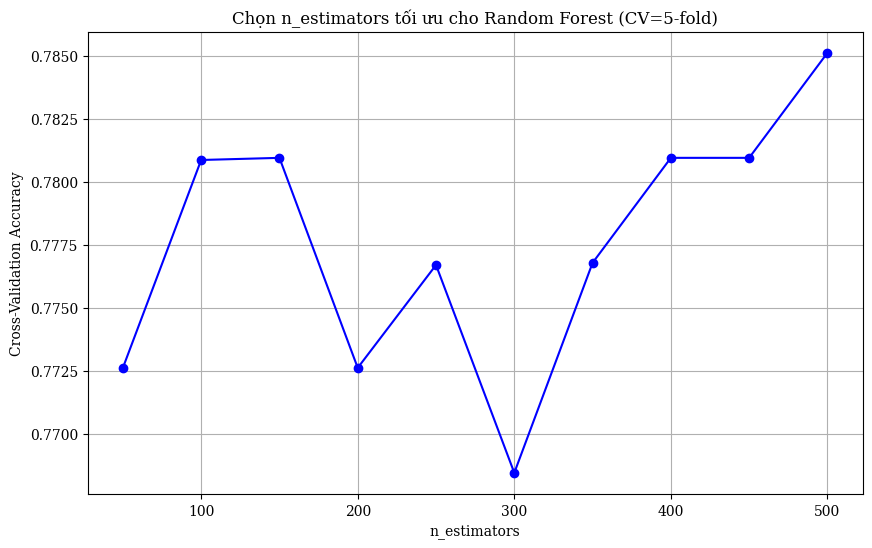

n_estimators tối ưu (CV): 500

Độ chính xác Random Forest trên tập validation: 0.9333
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.93      0.93      0.93        14

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30


Độ chính xác Random Forest trên tập test: 0.9032
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        17
           1       0.87      0.93      0.90        14

    accuracy                           0.90        31
   macro avg       0.90      0.91      0.90        31
weighted avg       0.91      0.90      0.90        31

14 s ± 577 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
# Time to run all 4: 56.2 s ± 1.36 s per loop (mean ± std. dev. of 7 runs, 1 loop each) - 7 minutes

# RF on Original DT Dataset
rf_model, val_dt_acc, best_params = evaluate_val_rf(X_dt_train, y_dt_train, X_dt_val, y_dt_val)
test_dt_acc = evaluate_test_rf(rf_model, X_dt_test, y_dt_test)

Tìm n_estimators tối ưu cho Random Forest...


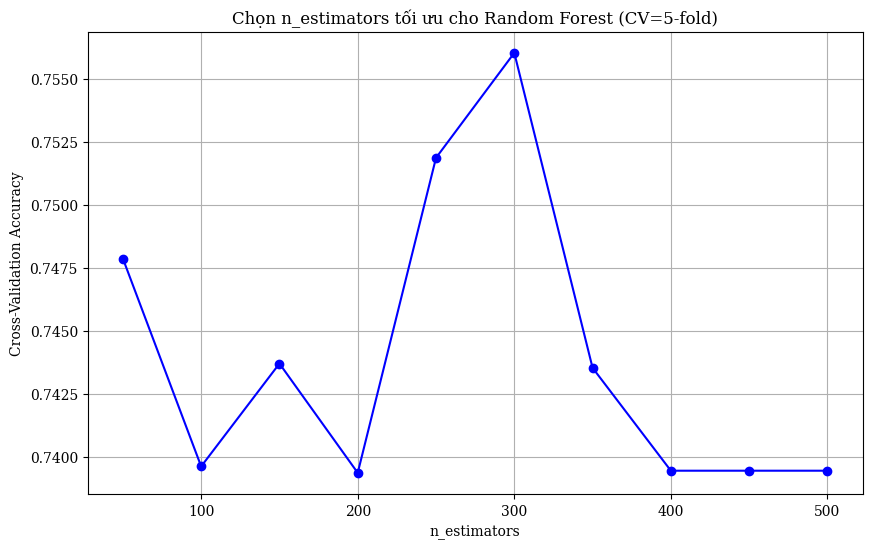

n_estimators tối ưu (CV): 300

Độ chính xác Random Forest trên tập validation: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        14

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


Độ chính xác Random Forest trên tập test: 0.8710
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        17
           1       0.86      0.86      0.86        14

    accuracy                           0.87        31
   macro avg       0.87      0.87      0.87        31
weighted avg       0.87      0.87      0.87        31



In [ ]:
# RF on Feature Engineering DT Dataset
rf_model, val_fe_dt_acc, best_params = evaluate_val_rf(X_fe_dt_train, y_fe_dt_train, X_fe_dt_val, y_fe_dt_val)
test_fe_dt_acc = evaluate_test_rf(rf_model, X_fe_dt_test, y_fe_dt_test)

### Plot validation vs test accuracy comparison
Bug: chạy code xong mất luôn biến đã lưu ở trên (ko hiểu vì sao)

In [ ]:
plt.rcParams['font.family'] = 'Serif'

labels = ['Original', 'FE', 'Original + DT', 'FE + DT']
val_accs = [val_acc, test_acc, val_dt_acc, test_dt_acc]
test_accs = [val_fe_acc, test_fe_acc, val_fe_dt_acc, test_fe_dt_acc]

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots(figsize=(5, 5))

rects1 = ax.bar(x - width/2, val_accs, width,
                label='Validation Accuracy',
                color='tab:blue', edgecolor='black', linewidth=1.2)
rects2 = ax.bar(x + width/2, test_accs, width,
                label='Test Accuracy',
                color='tab:red', edgecolor='black', linewidth=1.2)

ax.set_ylim(0.5, 1.05)
ax.set_ylabel('Accuracy')
ax.set_title('Random Forest', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(ncol=2, loc='upper center')

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.annotate(f'{h:.2f}', xy=(rect.get_x()+rect.get_width()/2, h),
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

NameError: name 'val_dt_acc' is not defined

# Ada Boost

## Find optimal n_estimators for AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from cuml.tree import DecisionTreeClassifier as cuDT  # GPU base learner

In [ ]:
def find_optimal_ada(
    X_train, y_train,
    n_estimators_range=range(50, 501, 50),
    cv_splits=3,
    learning_rate=0.1,
    base_max_depth=1,
    algorithm='SAMME'
):
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=SEED)
    scores = []
    for n in n_estimators_range:
        ada = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=base_max_depth, random_state=SEED),
            n_estimators=n, learning_rate=learning_rate,
            algorithm=algorithm, random_state=SEED
        )
        cv_score = cross_val_score(ada, X_train, y_train,
                                   cv=cv, scoring='accuracy')
        scores.append(cv_score.mean())

    plt.figure(figsize=(10, 6))
    plt.plot(list(n_estimators_range), scores, 'ro-')
    plt.title(f'Chọn n_estimators tối ưu cho AdaBoost (CV={cv_splits}-fold)')
    plt.xlabel('n_estimators')
    plt.ylabel('Cross-Validation Accuracy')
    plt.grid(True)
    plt.show()

    best_n = list(n_estimators_range)[int(np.argmax(scores))]
    print(f'n_estimators tối ưu (CV): {best_n}')

    adaboost_gpu = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(base_estimator=cuDT(max_depth=base_max_depth), random_state=SEED),
        n_estimators=best_n, learning_rate=learning_rate,
        algorithm=algorithm, random_state=SEED
    )
    adaboost_gpu.fit(X_train, y_train)
    adaboost_gpu = to_hb(adaboost_gpu)
    return adaboost_gpu, best_n, max(scores)

## Train/Validate & Test functions

In [ ]:
def evaluate_val_ada(
    X_train, y_train, X_val, y_val,
    n_estimators_range=range(50, 501, 50),
    cv_splits=3,
    learning_rate=0.1,
    base_max_depth=1,
    algorithm='SAMME'
):
    print('Tìm n_estimators tối ưu cho AdaBoost...')
    ada_model, best_n, cv_acc = find_optimal_ada(
        X_train, y_train,
        n_estimators_range=n_estimators_range,
        cv_splits=cv_splits,
        learning_rate=learning_rate,
        base_max_depth=base_max_depth,
        algorithm=algorithm
    )

    val_pred = ada_model.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    print(f'\nĐộ chính xác AdaBoost trên tập validation: {val_acc:.4f}')
    print('Classification Report:')
    print(classification_report(y_val, val_pred))
    return ada_model, val_acc, {'n_estimators': best_n}


def evaluate_test_ada(ada_model, X_test, y_test):
    test_pred = ada_model.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    print(f'\nĐộ chính xác AdaBoost trên tập test: {test_acc:.4f}')
    print('Classification Report:')
    print(classification_report(y_test, test_pred))
    return test_acc

### Run AdaBoost on 4 datasets

In [ ]:
# AdaBoost on Original Dataset
ada_model, val_acc, best_params = evaluate_val_ada(
    X_train, y_train, X_val, y_val
)
test_acc = evaluate_test_ada(ada_model, X_test, y_test)

# AdaBoost on Feature Engineering Dataset
ada_model, val_fe_acc, best_params = evaluate_val_ada(
    X_fe_train, y_fe_train, X_fe_val, y_fe_val
)
test_fe_acc = evaluate_test_ada(ada_model, X_fe_test, y_fe_test)

# AdaBoost on Original DT Dataset
ada_model, val_dt_acc, best_params = evaluate_val_ada(
    X_dt_train, y_dt_train, X_dt_val, y_dt_val
)
test_dt_acc = evaluate_test_ada(ada_model, X_dt_test, y_dt_test)

# AdaBoost on Feature Engineering DT Dataset
ada_model, val_fe_dt_acc, best_params = evaluate_val_ada(
    X_fe_dt_train, y_fe_dt_train, X_fe_dt_val, y_fe_dt_val
)
test_fe_dt_acc = evaluate_test_ada(ada_model, X_fe_dt_test, y_fe_dt_test)


## Plot validation vs test accuracy comparison

In [ ]:
plt.rcParams['font.family'] = 'Serif'

labels = ['Original', 'FE', 'Original + DT', 'FE + DT']
val_accs = [val_acc, val_fe_acc, val_dt_acc, val_fe_dt_acc]
test_accs = [test_acc, test_fe_acc, test_dt_acc, test_fe_dt_acc]

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots(figsize=(5, 5))

rects1 = ax.bar(x - width/2, val_accs, width,
                label='Validation Accuracy',
                color='tab:blue', edgecolor='black', linewidth=1.2)
rects2 = ax.bar(x + width/2, test_accs, width,
                label='Test Accuracy',
                color='tab:red', edgecolor='black', linewidth=1.2)

ax.set_ylim(0.5, 1.05)
ax.set_ylabel('Accuracy')
ax.set_title('AdaBoost', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(ncol=2, loc='upper center')

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.annotate(f'{h:.2f}', xy=(rect.get_x()+rect.get_width()/2, h),
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()


# XGBoost

### Find optimal n_estimators for XGBoost

In [ ]:
def find_optimal_xgb(
    X_train, y_train,
    n_estimators_range=range(50, 501, 50),
    cv_splits=3,
    learning_rate=0.1,
    max_depth=5,
    subsample=1.0,
    use_gpu=False
):
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=SEED)
    scores = []

    n_classes = len(np.unique(y_train))
    objective = 'binary:logistic' if n_classes == 2 else 'multi:softprob'
    eval_metric = 'logloss' if n_classes == 2 else 'mlogloss'

    for n in n_estimators_range:
        xgb = XGBClassifier(
            n_estimators=n,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=subsample,
            objective=objective,
            eval_metric=eval_metric,
            random_state=SEED,
            n_jobs=-1,
            tree_method='gpu_hist' if use_gpu else 'hist',
            verbosity=0
        )
        cv_score = cross_val_score(xgb, X_train, y_train,
                                   cv=cv, scoring='accuracy', n_jobs=-1)
        scores.append(cv_score.mean())

    plt.figure(figsize=(10, 6))
    plt.plot(list(n_estimators_range), scores, 'go-')
    plt.title(f'Chọn n_estimators tối ưu cho XGBoost (CV={cv_splits}-fold)')
    plt.xlabel('n_estimators')
    plt.ylabel('Cross-Validation Accuracy')
    plt.grid(True)
    plt.show()

    best_n = list(n_estimators_range)[int(np.argmax(scores))]
    print(f'n_estimators tối ưu (CV): {best_n}')

    best_model = XGBClassifier(
        n_estimators=best_n,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        objective=objective,
        eval_metric=eval_metric,
        random_state=SEED,
        n_jobs=-1,
        tree_method='gpu_hist' if use_gpu else 'hist',
        verbosity=0
    )
    best_model.fit(X_train, y_train)
    best_model = to_hb(best_model)
    return best_model, best_n, max(scores)

## Train/Validate & Test functions

In [ ]:
def evaluate_val_xgb(
    X_train, y_train, X_val, y_val,
    n_estimators_range=range(50, 501, 50),
    cv_splits=3,
    learning_rate=0.1,
    max_depth=5,
    subsample=1.0,
    colsample_bytree=1.0,
    use_gpu=False
):
    print('Tìm n_estimators tối ưu cho XGBoost...')
    xgb_model, best_n, cv_acc = find_optimal_xgb(
        X_train, y_train,
        n_estimators_range=n_estimators_range,
        cv_splits=cv_splits,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        use_gpu=use_gpu
    )

    val_pred = xgb_model.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    print(f'\nĐộ chính xác XGBoost trên tập validation: {val_acc:.4f}')
    print('Classification Report:')
    print(classification_report(y_val, val_pred))
    return xgb_model, val_acc, {'n_estimators': best_n}


def evaluate_test_xgb(xgb_model, X_test, y_test):
    test_pred = xgb_model.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    print(f'\nĐộ chính xác XGBoost trên tập test: {test_acc:.4f}')
    print('Classification Report:')
    print(classification_report(y_test, test_pred))
    return test_acc

## Run XGBoost on 4 datasets

In [ ]:
# XGBoost on Original Dataset
xgb_model, val_acc, best_params = evaluate_val_xgb(
    X_train, y_train, X_val, y_val, use_gpu=False
)
test_acc = evaluate_test_xgb(xgb_model, X_test, y_test)

# XGBoost on Feature Engineering Dataset
xgb_model, val_fe_acc, best_params = evaluate_val_xgb(
    X_fe_train, y_fe_train, X_fe_val, y_fe_val, use_gpu=False
)
test_fe_acc = evaluate_test_xgb(xgb_model, X_fe_test, y_fe_test)

# XGBoost on Original DT Dataset
xgb_model, val_dt_acc, best_params = evaluate_val_xgb(
    X_dt_train, y_dt_train, X_dt_val, y_dt_val, use_gpu=False
)
test_dt_acc = evaluate_test_xgb(xgb_model, X_dt_test, y_dt_test)

# XGBoost on Feature Engineering DT Dataset
xgb_model, val_fe_dt_acc, best_params = evaluate_val_xgb(
    X_fe_dt_train, y_fe_dt_train, X_fe_dt_val, y_fe_dt_val, use_gpu=False
)
test_fe_dt_acc = evaluate_test_xgb(xgb_model, X_fe_dt_test, y_fe_dt_test)


### Plot validation vs test accuracy comparison

In [ ]:
plt.rcParams['font.family'] = 'Serif'

labels = ['Original', 'FE', 'Original + DT', 'FE + DT']
val_accs = [val_acc, val_fe_acc, val_dt_acc, val_fe_dt_acc]
test_accs = [test_acc, test_fe_acc, test_dt_acc, test_fe_dt_acc]

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots(figsize=(5, 5))

rects1 = ax.bar(x - width/2, val_accs, width,
                label='Validation Accuracy',
                color='tab:blue', edgecolor='black', linewidth=1.2)
rects2 = ax.bar(x + width/2, test_accs, width,
                label='Test Accuracy',
                color='tab:red', edgecolor='black', linewidth=1.2)

ax.set_ylim(0.5, 1.05)
ax.set_ylabel('Accuracy')
ax.set_title('XGBoost', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(ncol=2, loc='upper center')

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.annotate(f'{h:.2f}', xy=(rect.get_x()+rect.get_width()/2, h),
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()